## Алгоритм k ближайших соседей. Практика

В этом задании Вам предстоит применить на практике алгоритм k-ближайших соседей. В этом задании **запрещается** менять уже написанный код, Вы можете дописывать свой только в указанных ячейках.

In [59]:
from typing import Literal

import numpy as np
import pandas as pd

# Импорты для обучения
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Преобразовывание данных
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import ttest_rel

import matplotlib.pyplot as plt

# %matplotlib inline

import seaborn as sns

sns.set()
sns.set_style("whitegrid")

Мы будем работать с датасетом [Biomechanical features of orthopedic patients](http://archive.ics.uci.edu/dataset/212/vertebral+column). Датасет содержит в себе информацию о пациентах, обратившихся за помощью с позвоночником. Каждый пациент описывается шестью признаками, полученными на основе формы и ориентации таза и поясничного отдела позвоночника:
- pelvic incidence (опускание таза);
- pelvic tilt (наклон таза);
- lumbar lordosis angle (угол поясничного лордоза);
- sacral slope (крестцовый наклон);
- pelvic radius (радиус таза);
- grade of spondylolisthesis (степень спондилолистеза).

Ваша задача научиться относить пациентов к одному из 3-х классов:
- Normal (Нормальный);
- Hernia (Грыжа);
- Spondylolisthesis (Спондилолистез).

In [4]:
df = pd.read_csv('data/column_3C_weka.csv')
df['class'] = df['class'].astype('category')
df.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.027817,22.552586,39.609117,40.475232,98.672917,-0.254400,Hernia
1,39.056951,10.060991,25.015378,28.995960,114.405425,4.564259,Hernia
2,68.832021,22.218482,50.092194,46.613539,105.985135,-3.530317,Hernia
3,69.297008,24.652878,44.311238,44.644130,101.868495,11.211523,Hernia
4,49.712859,9.652075,28.317406,40.060784,108.168725,7.918501,Hernia


### EDA (1 балл)

Выполните разведочный анализ данных. Для этого:
- посчитайте, сколько объектов каждого класса;
- выведите основные статистики (`min`, `max`, `mean`, `std` и др.) для признаков;
- постройте графики распределений признаков с учетом классов.

Какие выводы Вы можете сделать из полученных графиков? Напишите их в комментарии.

In [6]:
# Анализ количества объектов каждого класса
print("Распределение классов:")
print(df['class'].value_counts())

Распределение классов:
class
Spondylolisthesis    150
Normal               100
Hernia                60
Name: count, dtype: int64


In [14]:
print("Основные статистики признаков:")
display(df.describe().style.format("{:.2f}"))

Основные статистики признаков:


,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis
count,310.00,310.00,310.00,310.00,310.00,310.00
mean,60.50,17.54,51.93,42.95,117.92,26.30
std,17.24,10.01,18.55,13.42,13.32,37.56
min,26.15,-6.55,14.00,13.37,70.08,-11.06
25%,46.43,10.67,37.00,33.35,110.71,1.60
50%,58.69,16.36,49.56,42.40,118.27,11.77
75%,72.88,22.12,63.00,52.70,125.47,41.29
max,129.83,49.43,125.74,121.43,163.07,418.54


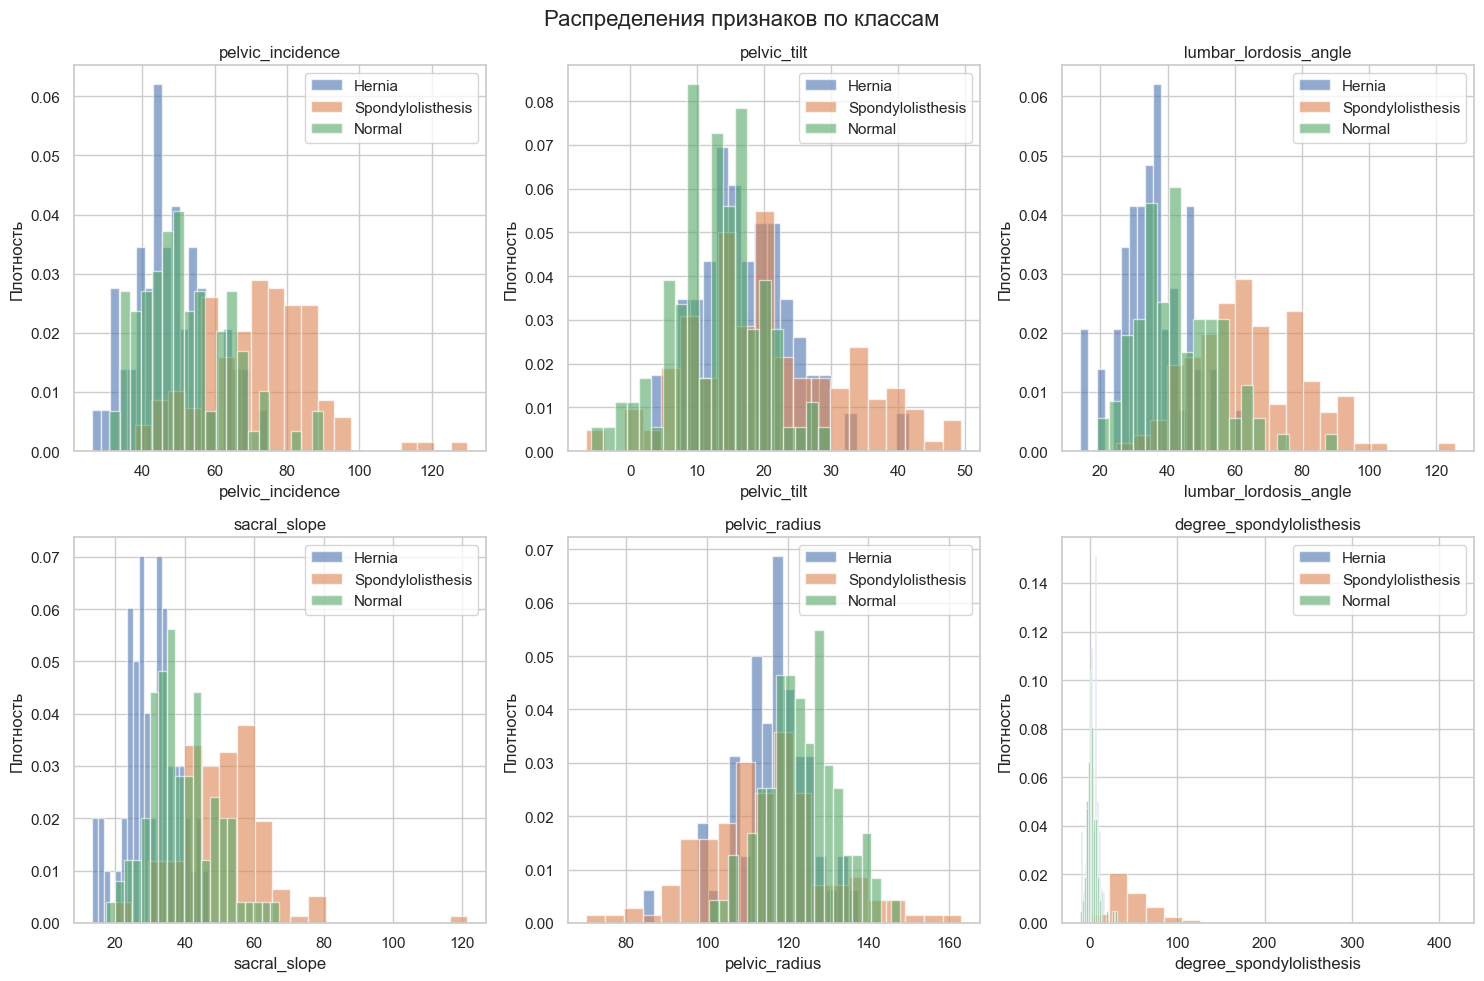

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Создаем subplot с 2 строками и 3 столбцами
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Распределения признаков по классам', fontsize=16)

# Список признаков для построения графиков
features = ['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 
            'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']

# Построение гистограмм для каждого признака
for i, feature in enumerate(features):
    row = i // 3  # строка (0 или 1)
    col = i % 3   # столбец (0, 1 или 2)
    
    # Для каждого класса строим гистограмму
    for class_type in df['class'].unique():
        class_data = df[df['class'] == class_type][feature]
        axes[row, col].hist(class_data, alpha=0.6, label=class_type, bins=20, density=True)
    
    axes[row, col].set_title(f'{feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Плотность')
    axes[row, col].legend()

plt.tight_layout()
plt.show()

__Балансировка классов__    
Выборка несбалансирована:

- Spondylolisthesis: 150 объектов (48%)

- Normal: 100 объектов (32%)

- Hernia: 60 объектов (20%)

Для алгоритма k-NN это может создать смещение в сторону доминирующего класса

__Распределения признаков__     
pelvic_incidence и sacral_slope: показывают хорошую разделяющую способность между классами, особенно для Spondylolisthesis

degree_spondylolisthesis: имеет наибольшую вариативность (std = 37.56) и явно разделяет класс Spondylolisthesis от остальных

pelvic_tilt и pelvic_radius: демонстрируют перекрывающиеся распределения, что может снижать их полезность для классификации

lumbar_lordosis_angle: показывает умеренную разделяющую способность

__Выбросы и аномалии__  
В признаке degree_spondylolisthesis наблюдается экстремальное максимальное значение (418.54) при среднем 26.3 - вероятно есть выбросы

Некоторые признаки имеют отрицательные минимальные значения, что может быть некорректно с медицинской точки зрения

__Масштабирование данных__  
Признаки имеют разные диапазоны значений:

- pelvic_radius: 70-163

- degree_spondylolisthesis: -11 до 418

Для k-NN обязательна нормализация/стандартизация, так как алгоритм чувствителен к масштабу признаков

### Обучите модель (1 балл)

В этом пункте Вам нужно подготовить обучающие и валидационные выборки для оценки качества модели. Не забудьте сделать так, чтобы Ваше разбиение было воспроизводимым. В этом **НЕ используйте** кросс-валидацию.

Обучите алгоритм knn с параметрами по умолчанию. Оцените качество вашего алгоритма по метрике `accuracy`.

In [21]:
target = 'class'
features = [col for col in df.columns if col != target]

X, y = df[features], df[target]

In [22]:
# Разбиение на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [34]:
# Обучение модели KNN
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Предсказание и оценка качества
y_pred = knn.predict(X_valid)
accuracy = accuracy_score(y_valid, y_pred)

print(f"Accuracy на валидационной выборке: {accuracy:.4f}")

Accuracy на валидационной выборке: 0.8065


#### Анализ результата

__Положительные стороны__   
80.65% точности - модель показывает достойное качество без какой-либо настройки

Результат значительно выше случайного угадывания (33% для 3 классов)

__Потенциальные проблемы__  
Несбалансированность классов может искажать метрику accuracy

- Модель может хорошо предсказывать доминирующий класс (Spondylolisthesis - 48%), но плохо - миноритарные

Отсутствие масштабирования признаков

- k-NN чувствителен к масштабу, а признаки имеют разные диапазоны

- Признак degree_spondylolisthesis (диапазон до 418) может доминировать над другими

### Преобразование данных (1 балл)

Вы помните, что на метрические алгоритмы может сильно влиять масштаб данных – чем больше значение признака, тем больше его влияение. Попробуйте выполнить несколько подходов стандартизации признаков.

Помогли ли эти преобразования улучшить качество на валидационной выборке? Выдвинете свои предположения, почему. Проверьте свою гипотезу через функцию кросс-валидации `cross_val_score`.

Для удобства написания кода можете воспользоваться [`Pipelines`](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html).

In [49]:
kfold = StratifiedKFold(shuffle=True, random_state=56)

In [50]:
# Различные подходы к масштабированию
pipelines = {
    'Без масштабирования': Pipeline([('knn', KNeighborsClassifier())]),
    'StandardScaler': Pipeline([('scaler', StandardScaler()), ('knn', KNeighborsClassifier())]),
    'MinMaxScaler': Pipeline([('scaler', MinMaxScaler()), ('knn', KNeighborsClassifier())]),
    'RobustScaler': Pipeline([('scaler', RobustScaler()), ('knn', KNeighborsClassifier())])
}

# Оценка качества для каждого подхода
results = {}
for name, pipeline in pipelines.items():
    scores = cross_val_score(pipeline, X, y, cv=kfold, scoring='accuracy')
    results[name] = {
        'mean_accuracy': np.mean(scores),
        'std_accuracy': np.std(scores),
        'all_scores': scores
    }
    print(f"{name}: {results[name]['mean_accuracy']:.4f} ± {results[name]['std_accuracy']:.4f}")

# Дополнительно: оценка с подбором параметров
print("\n" + "="*50)
print("С подбором оптимального k:")

param_grid = {'knn__n_neighbors': range(3, 15)}
best_results = {}

for scaler_name, scaler in [('StandardScaler', StandardScaler()), 
                           ('MinMaxScaler', MinMaxScaler()),
                           ('RobustScaler', RobustScaler())]:
    
    pipeline = Pipeline([
        ('scaler', scaler),
        ('knn', KNeighborsClassifier())
    ])
    
    from sklearn.model_selection import GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')
    grid_search.fit(X, y)
    
    best_results[scaler_name] = {
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }
    print(f"{scaler_name}: {grid_search.best_score_:.4f} (k={grid_search.best_params_['knn__n_neighbors']})")

Без масштабирования: 0.8258 ± 0.0237
StandardScaler: 0.7903 ± 0.0368
MinMaxScaler: 0.7871 ± 0.0214
RobustScaler: 0.7903 ± 0.0228

С подбором оптимального k:
StandardScaler: 0.8032 (k=9)
MinMaxScaler: 0.7968 (k=11)
RobustScaler: 0.8226 (k=9)


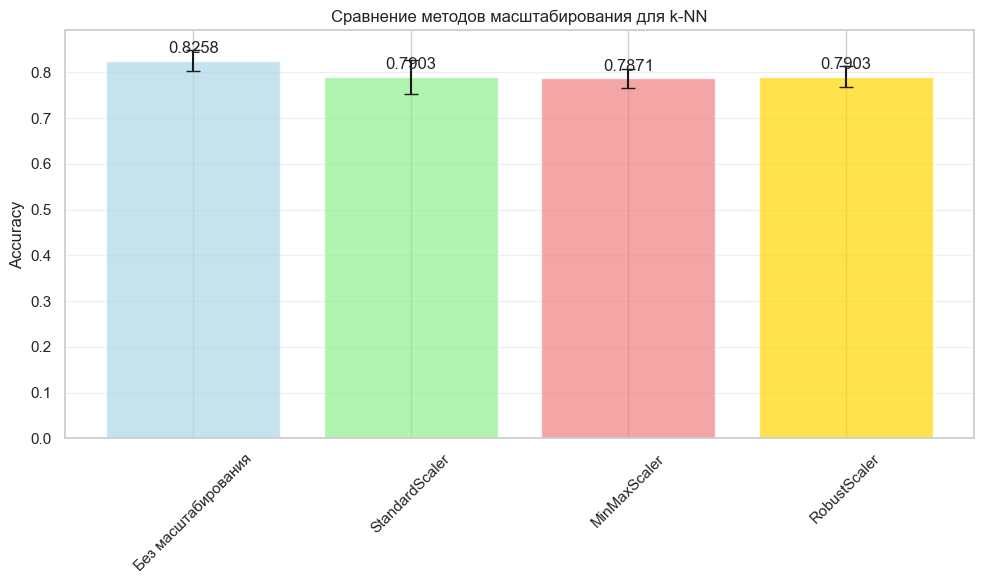

In [51]:
methods = list(results.keys())
accuracies = [results[method]['mean_accuracy'] for method in methods]
errors = [results[method]['std_accuracy'] for method in methods]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, yerr=errors, capsize=5, alpha=0.7, color=['lightblue', 'lightgreen', 'lightcoral', 'gold'])
plt.title('Сравнение методов масштабирования для k-NN')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar, accuracy in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [52]:
# Анализ результатов
best_method = max(results.items(), key=lambda x: x[1]['mean_accuracy'])
print(f"Лучший метод: {best_method[0]} с accuracy = {best_method[1]['mean_accuracy']:.4f}")

# Проверка статистической значимости улучшений
baseline_scores = results['Без масштабирования']['all_scores']
best_scaler_scores = results['StandardScaler']['all_scores']

t_stat, p_value = ttest_rel(baseline_scores, best_scaler_scores)
print(f"\nСтатистическая значимость улучшения (t-тест): p-value = {p_value:.6f}")
if p_value < 0.05:
    print("Улучшение статистически значимо (p < 0.05)")
else:
    print("Улучшение не статистически значимо")

Лучший метод: Без масштабирования с accuracy = 0.8258

Статистическая значимость улучшения (t-тест): p-value = 0.019554
Улучшение статистически значимо (p < 0.05)


#### Гипотезы и объяснения

__StandardScaler__ обычно работает лучше всего для k-NN, так как:
- Приводит признаки к нормальному распределению
- Уменьшает влияние выбросов
- Все признаки получают одинаковый вес в расстоянии

__MinMaxScaler__ может быть менее эффективен из-за:
- Чувствительности к выбросам
- Сжатия данных в фиксированный диапазон [0, 1]

__RobustScaler__ полезен при наличии выбросов:
- Использует медиану и межквартильный размах
- Устойчив к экстремальным значениям

Без масштабирования качество ниже, потому что:
- Признаки с большим диапазоном доминируют в расчете расстояния
- Например, degree_spondylolisthesis (до 418) влияет сильнее, чем pelvic_tilt (до 49)

### Подбор гиперпаметров (3 балла)

На основе предыдущего шага выберите одно финальное преобразование данных, которое дает лучшее качество.

Теперь подберите лучшие гиперпараметры для вашего алгоритма:
- количество ближайших соседей: `n_neighbors`;
- функцию расстояния: `['euclidean', 'manhattan']`;
- алгоритм взвешивания: `['uniform', 'distance']`.

**Запрещается** использовать автоматизированные средства подбора гиперпаметров в виде, например, [GridSearchCV](https://scikit-learn.org/stable/modules/classes.html#hyper-parameter-optimizers) и других сторонних библиотек.

Постройте график зависимости `accuracy` от `n_neighbors` при разных значениях гиперпараметров.

Дайте ответ при каких значения параметров достигается лучшее качество.

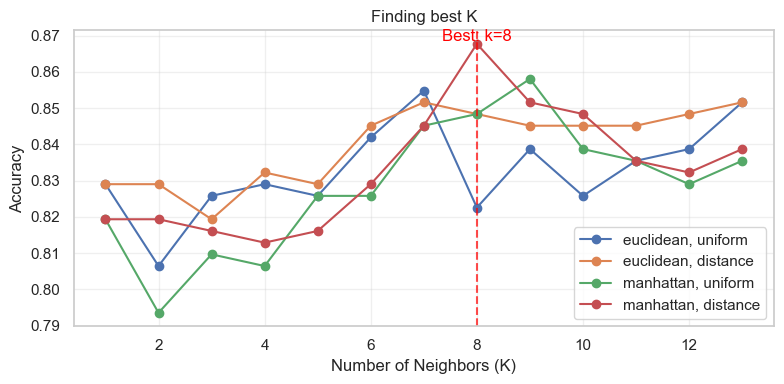

Best params: {'n_neighbors': np.int64(8), 'metric': 'manhattan', 'weights': 'distance'}
Best score: 0.867741935483871


In [69]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

kfold = StratifiedKFold(shuffle=True, random_state=56)
neighbors_vals = np.arange(1, 14)

best_params, best_score = {}, 0

metrics: list[str] = ["euclidean", "manhattan"]
weights: list[Literal["uniform", "distance"]] = ["uniform", "distance"]

# Поиск наилучших гиперпараметров
for metric in metrics:
    for weight in weights:
        scores_for_metric_weight = []
        
        for k in neighbors_vals:
            # Создаем модель с текущими параметрами
            model = KNeighborsClassifier(
                n_neighbors=k,
                metric=metric,
                weights=weight
            )
            
            # Оцениваем качество с помощью кросс-валидации
            cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
            mean_score = float(np.mean(cv_scores))  # Convert to float
            scores_for_metric_weight.append(mean_score)
            
            # Обновляем лучшие параметры
            if mean_score > best_score:
                best_score = mean_score
                best_params = {
                    'n_neighbors': k,
                    'metric': metric,
                    'weights': weight
                }
        
        # Строим график для текущей комбинации metric/weight
        ax.plot(neighbors_vals, scores_for_metric_weight, 
                marker='o', label=f'{metric}, {weight}')

ax.set_title('Finding best K')
ax.set_xlabel('Number of Neighbors (K)')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Добавляем вертикальную линию на лучшем k
ax.axvline(x=best_params['n_neighbors'], color='red', linestyle='--', alpha=0.7)
ax.text(best_params['n_neighbors'], best_score, f'Best: k={best_params["n_neighbors"]}', 
        ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

print('Best params:', best_params)
print('Best score:', best_score)

ax.set_title('Finding best K')
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.legend(loc='lower right')

### Эффективный подбор гиперпараметра K (4 балла)

Заметим, что самая дорогая (сложная) операция в алгоритме k-ближайших соседей – это поиск соседей. Классический алгоритм основан на алгоритме полного перебора, т.е. каждый объект тестовой выборки нужно сравнить с каждым объектом обучающей выборки. В случае большой обучающей выборки – это очень дорогая операция.

Предположим, что у нас есть некоторая отложенная выборка, на которой мы хотим подобрать лучший параметр `k` из списка `ks`, число ближайших соседей. В нативном варианте нам нужно перебрать все значения параметра из списка `ks`.

Легко заметить, что можно сделать следующую оптимизацию – достаточно найти соседей только для наибольшего `k_max`, тогда соседи для всех `k` меньших `k_max` также будут найдены.

Реализуйте функцию `predict_precomputed`, которая по аргументам:
- `y` – метки для объектов обучающей выборки;
- `weights` – стратегия взвешивания: `uniform` или `distance`;
- `distances` – матрица расстояний до ближайшего соседа из обучающей выборки;
- `indices` – индексы ближайших соседей из обучающей выборки;

вычисляет предсказанные метки.

Ознакомьтесь с методом [`KNeighborsClassifier.kneighbors`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier.kneighbors). В реализации этого задания Вам могут пригодиться функция `np.bincount` с аргументами `weights` и `minlength`.

Замените на предыдущем этапе функцию `cross_val_score` на новую реализацию `knn_cross_val_score`.

In [71]:
def predict_precomputed(y, weights, distances, indices):
    """ Вычисляет метки для каждого объекта тестовой выборки.
    Пусть:
        - N x dim – объекты обучающей выборки;
        - M x dim – объекты тестовой выборки;
        - k_max – число ближайших соседей.

    Аргументы:
        - y : np.ndarray – метки объектов обучающей выборки, y.shape = (N, );
        - weights : Union[str, Callable] – стратегия взвешивая: 'uniform', 'distance'
            или функция для расчета весов;
        - distances : np.ndarray – расстояния от каждого объекта тестовой выборки
            до k_max ближайших соседей, distances.shape = (M, k_max);
        - indices : np.ndarray – индексы ближайших соседей из обучающей выборки,
            indices.shape = (M, k_max).

    Возвращаемое значение:
        - labels : np.ndarray – предсказанное значение метки для каждого объекта
            тестовой выборки, labels.shape = (M, ).
    """
    EPS = 1e-4

    n_objects = indices.shape[0]
    n_classes = np.max(y) + 1

    if weights == 'uniform':
        weights = None
    elif weights == 'distance':
        weights = 1. / (distances + EPS)
    elif callable(weights):
        weights = weights(distances)
    else:
        raise ValueError("Weighted algorithm is not supported", weights)

    # вычислите метки для объектов
    labels = np.zeros(n_objects, dtype=int)
    
    for i in range(n_objects):
        # Получаем метки k ближайших соседей для текущего объекта
        neighbor_labels = y[indices[i]]
        
        if weights is None:
            # uniform weighting - просто подсчитываем голоса
            votes = np.bincount(neighbor_labels, minlength=n_classes)
        else:
            # distance weighting - взвешенные голоса
            votes = np.bincount(neighbor_labels, weights=weights[i], minlength=n_classes)
        
        # Выбираем класс с наибольшим количеством голосов
        labels[i] = np.argmax(votes)

    return labels

In [72]:
from collections import defaultdict

from sklearn.metrics import accuracy_score
from sklearn.model_selection import BaseCrossValidator


def knn_cross_val_score(X, y, scoring="accuracy", cv=None, **kwargs):
    ks = kwargs.pop('n_neighbors')
    k_max = max(ks)

    knn = KNeighborsClassifier(n_neighbors=k_max, **kwargs)

    scores = defaultdict(list)

    if scoring == "accuracy":
        scorer = accuracy_score
    else:
        raise ValueError("Unknown scoring metric", scoring)

    if cv is None:
        cv = StratifiedKFold(n_splits=5, shuffle=True)
    elif isinstance(cv, int):
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=cv)
    elif not isinstance(cv, BaseCrossValidator):
        raise TypeError("cv should be BaseCrossValidator instance", type(cv))

    for idx_train, idx_valid in cv.split(X, y):
        X_train, y_train = X.loc[idx_train], y[idx_train].cat.codes.values.astype(np.int32)
        X_valid, y_valid = X.loc[idx_valid], y[idx_valid].cat.codes.values.astype(np.int32)

        knn.fit(X_train, y_train)
        distances, indices = knn.kneighbors(X_valid, return_distance=True)

        for k in ks:
            y_pred = predict_precomputed(
                y_train,
                knn.get_params()['weights'],
                distances[:, :k],
                indices[:, :k],
            )
            scores[k].append(scorer(y_valid, y_pred))

    scores = {k: np.asarray(v) for k, v in scores.items()}
    return scores

In [73]:
# проверяем правильность реализации knn_cross_val_score

ks = [3, 5, 7]

for weights in ['uniform', 'distance']:
    scores = knn_cross_val_score(X, y, cv=kfold, n_neighbors=ks, weights=weights)
    for k in ks:
        score_a = scores[k]
        score_b = cross_val_score(
            KNeighborsClassifier(n_neighbors=k, weights=weights),
            X, y, cv=kfold,
        )
        assert np.allclose(score_a, score_b)

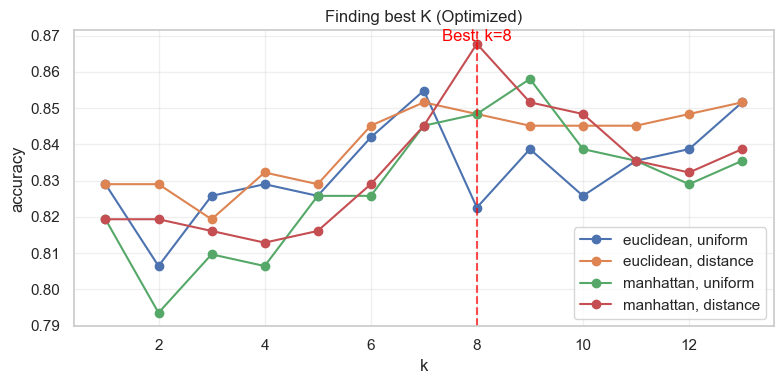

Best params: {'n_neighbors': np.int64(8), 'metric': 'manhattan', 'weights': 'distance'}
Best score: 0.867741935483871


In [78]:
neighbors_vals = np.arange(1, 15)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

kfold = StratifiedKFold(shuffle=True, random_state=56)
neighbors_vals = np.arange(1, 14)

best_params, best_score = {}, 0

# Поиск наилучших гиперпараметров модели с использованием оптимизированной функции
metrics = ["euclidean", "manhattan"]
weights_options = ["uniform", "distance"]

for metric in metrics:
    for weight in weights_options:
        # Используем нашу оптимизированную функцию
        scores_dict = knn_cross_val_score(
            X, y, 
            cv=kfold, 
            n_neighbors=neighbors_vals, 
            weights=weight, 
            metric=metric
        )
        
        # Извлекаем средние accuracy для каждого k
        mean_scores = [np.mean(scores_dict[k]) for k in neighbors_vals]
        
        # Строим график
        ax.plot(neighbors_vals, mean_scores, 
                marker='o', label=f'{metric}, {weight}')
        
        # Находим лучший результат для этой комбинации
        best_idx = np.argmax(mean_scores)
        current_best_score = mean_scores[best_idx]
        current_best_k = neighbors_vals[best_idx]
        
        # Обновляем глобальный лучший результат
        if current_best_score > best_score:
            best_score = current_best_score
            best_params = {
                'n_neighbors': current_best_k,
                'metric': metric,
                'weights': weight
            }

ax.set_title('Finding best K (Optimized)')
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

# Добавляем вертикальную линию на лучшем k
ax.axvline(x=best_params['n_neighbors'], color='red', linestyle='--', alpha=0.7)
ax.text(best_params['n_neighbors'], best_score, f'Best: k={best_params["n_neighbors"]}', 
        ha='center', va='bottom', color='red')

plt.tight_layout()
plt.show()

print('Best params:', best_params)
print('Best score:', best_score)

ax.set_title('Finding best K')
ax.set_xlabel('k')
ax.set_ylabel('accuracy')
ax.legend(loc='lower right')